In [1]:
import ashd, sep
import ashd.pipelinev2 as pv2
from ashd.pipelinev2.reader import Reader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

import math, os

from astropy import visualization
from astropy.table import Table
from astropy.coordinates import SkyCoord

from astropy.visualization import ImageNormalize, SqrtStretch

%matplotlib inline

sns.set()
plt.rcParams["figure.figsize"] = [12, 12]


In [2]:
r = Reader('/home/me/Code/Research/results/algo1_run3')
d = r.data

In [3]:
d['zeropt'] = [r.get_img(x).header['ZEROPT'] for x in range(len(d))]

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(24,12));
fig.suptitle("# of pixels vs flux")

z = np.polyfit(d['npix'], d['flux'], 1)
p = np.poly1d(z)

ax[0].set(xlabel="Number of pixels", ylabel="Flux")
ax[0].plot(d['npix'], d['flux'], 'o');
ax[0].plot(d['npix'], p(d['npix']), "r--");

d2 = d[d['npix'] > 20000][d['flux'] < 3e7]
ax[1].set(xlabel="Truncated npix", ylabel="Flux")
ax[1].plot(d2['npix'], d2['flux'], 'o');
ax[1].plot(d2['npix'], p(d2['npix']), "r--");


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(24,12));
fig.suptitle("Distribution plots")
ax[0].set(title="# of pixels"); ax[1].set(title="Flux")
sns.distplot(d['npix'], ax=ax[0]);
sns.distplot(d['flux'], ax=ax[1], color="red");

In [6]:
magnitude = lambda f, m0: m0 - 2.5*math.log10(f)
mag = lambda x: magnitude(d['flux'][x] / d['npix'][x], r.get_img(x).header['ZEROPT'])

In [7]:
d['mag'] = d['zeropt'] - 2.5 * np.log10(d['flux'])
d['muavg'] = d['mag'] + 2.5 * np.log10(d['npix'] * ashd.utils.pixscale**2)

In [8]:
vavg = np.average(d['mag'], weights=d['npix'])

In [ ]:
plt.xlabel(f"Magnitude (Weighted Average: {vavg:.4f})"); plt.ylabel("Surface Area")
plt.plot(d['mag'], d['npix'], 'o');
plt.axvline(vavg, color='r')

In [20]:
dwarfs = Table.read('../data/nearby-dwarfs.fits')
dwarfs.rename_column('_RAJ2000', 'ra')
dwarfs.rename_column('_DEJ2000', 'dec')
#dwarfs = dwarfs[(~np.isnan(dwarfs['muV'])) & (~np.isnan(dwarfs['R1']))]
#dwarfs = dwarfs[(dwarfs['R1']<10) & (dwarfs['R1']>2) & (dwarfs['muV']<26.4) & (dwarfs['muV']>23)]

In [21]:
coords = SkyCoord(d['ra'], d['dec'], unit='deg')
dwarf_coords = SkyCoord(dwarfs['ra'], dwarfs['dec'], unit='deg')

idx, sep2d, _ = dwarf_coords.match_to_catalog_sky(coords)

In [ ]:
plt.plot(d['mag'], d['npix'], 'o');
plt.plot(d['mag'][idx], d['npix'][idx], 'o', color='r');

In [23]:
#norm = mpl_normalize.ImageNormalize(
#    stretch=visualization.SqrtStretch())

#norm2 = 

def plotme(obj, rng=[10, 99], target=None, label=None):
    vmin, vmax = np.percentile(obj, rng)
    k = target if target != None else plt
    inorm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())
    k.imshow(obj, cmap="Greys_r", norm=inorm, origin='lower')
    if label: k.set(title=label)

In [ ]:
sns.reset_orig()
cols = 3
fig, ax = plt.subplots(ncols = cols, nrows = len(dwarfs) // cols, sharex=True)
for i in range(len(idx)):
    id_ = int(idx[i])
    #plotme(r.get_img(id_).data, target = ax[i // cols, i % cols], label=dwarfs['Name'][i])

In [28]:
b = ashd.Butler('/run/media/me/DATA/asas-sn-images')
sns.reset_orig()

/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [24]:
xlength = lambda x: d['xmax'][x] - d['xmin'][x]

def patch(idx, bar, **kwargs):
    x, y, a, b, theta = [kwargs.get(n, d[n][idx]) for n in ('x', 'y', 'a', 'b', 'theta')]
    e = patches.Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    if not bar: return (e,)
    
    e2 = patches.Rectangle(xy=(d['xmin'][idx], d['ymax'][idx]),
                           width=xlength(idx),
                           height=2,
                          label="Test")
    return (e, e2)

def get_frame(idx):
    return b.get_image(ra=d['ra'][idx], dec = d['dec'][idx])

def show(idx, ax=None, text=True, label=None, patches=True):
    if ax == None: fig, ax = plt.subplots();
    #data = get_frame(idx).data[]
    plotme(get_frame(idx).data, rng=[10,99], target=ax);
    if patches:
        for i in patch(idx, bar=text): ax.add_artist(i)
        if text: ax.text(d['xmin'][idx], d['ymax'][idx] + 5, f"{(xlength(idx) * 7.8):.2f}\"", color="orange", fontsize=20)
    ax.set_xlim(d['xmin'][idx] - 20, d['xmax'][idx] + 20)
    ax.set_ylim(d['ymin'][idx] - 20, d['ymax'][idx] + 20)
    ax.set(xlabel=label if label else ', '.join([f"{d[x][idx]:.2f}" for x in ('ra', 'dec')]))
    #plt.savefig(out if out else f"scanlations/{idx}.png");

In [17]:
filter1 = (d['x'] < 100) | (d['x'] > 1950) | (d['y'] < 100) | (d['y'] > 1950)
filter2 = (d['a'] / d['b']) > 3.5

len(d[~(filter2 | filter1)])

3104

In [5]:
import pickle
from astropy.io import fits

In [6]:
f = open('state.bin', 'rb')
hd = pickle.load(f)
f.close()

In [40]:
v = lambda x: 'd' if x == True else x
k = lambda x: 'n' if x == False else x

d['ooi'] = [k(v(hd.get(i, 'n'))) for i in range(len(d))]
ooi = d[d['ooi'] == 'u']#[0:10] #objects of interest

In [41]:
len(ooi)

98

In [ ]:
cols = 6
rows = int(np.ceil(len(ooi) / cols))
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(24, 6*rows))
pos = 0
for index, row in ooi.iterrows():
    show(index, ax=ax[pos // cols, pos % cols])
    pos += 1

In [ ]:
sns.set()
plt.xlabel(f"Magnitude"); plt.ylabel("Surface Area")
plt.plot(d['mag'], d['npix'], 'o', markersize=2);
plt.plot(ooi['mag'], ooi['npix'], 'o', markersize=2, color='r');

In [18]:
galaxies = Table.read("../data/updated-nearby-galaxy-catalog.fits")
galaxies.rename_column('_RAJ2000', 'ra')
galaxies.rename_column('_DEJ2000', 'dec')
galaxy_coords = SkyCoord(galaxies['ra'], galaxies['dec'], unit='deg')

In [42]:
ooi_coords = SkyCoord(ooi['ra'], ooi['dec'], unit='deg')

idx, sep2d, _ = ooi_coords.match_to_catalog_sky(dwarf_coords)

gidx, gsep, _ = ooi_coords.match_to_catalog_sky(galaxy_coords)

names = {}
for i in range(len(idx)):
    j = idx[i]
    g = gidx[i]
    names[i] = ""
    
    if sep2d.deg[i] < 4/60:
        names[i] += f"From dwarfs: {dwarfs['Name'][j]}; {sep2d.deg[i]:.2f}° sep\n"
    if gsep.deg[i] < 4/60:
        names[i] += f"From galaxies: {galaxies['Name'][g]}; {gsep.deg[i]:.2f}° sep\n"
    else:
        names[i] += "UNKNOWN\n"

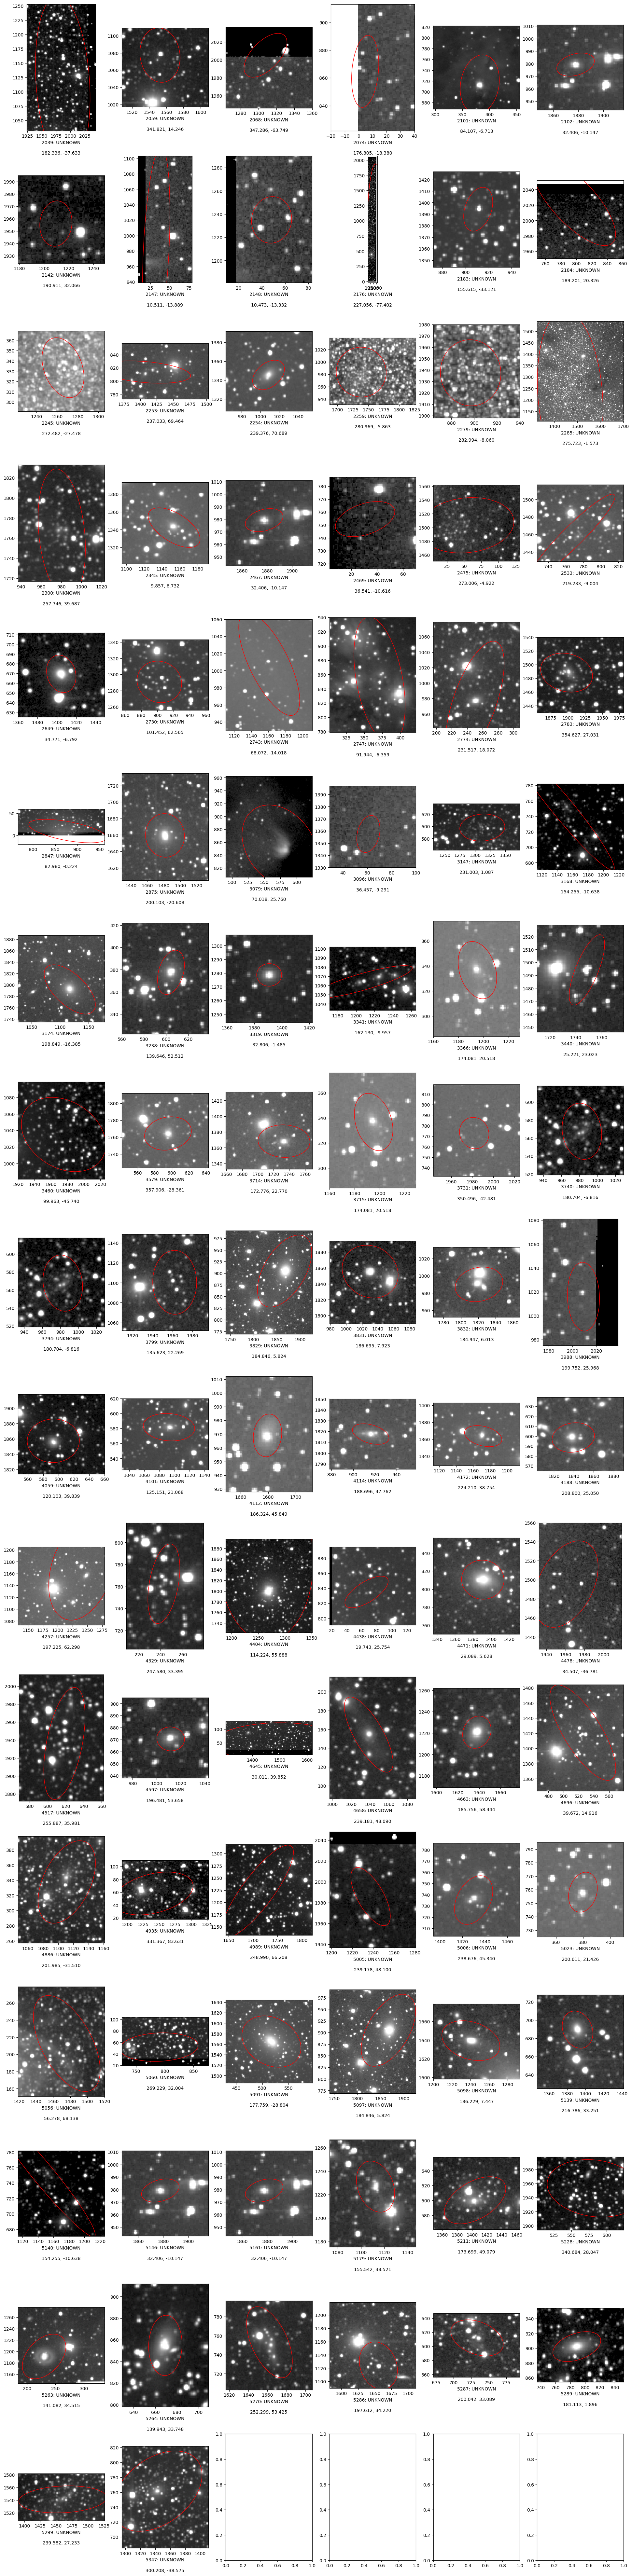

In [43]:
cols = 6
rows = int(np.ceil(len(ooi) / cols))
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(24, 6*rows))
pos = 0
for index, row in ooi.iterrows():
    show(index, ax=ax[pos // cols, pos % cols], text=False, label=str(index) + ": " + str(names[pos] + f"\n{d['ra'][index]:.3f}, {d['dec'][index]:.3f}"))
    pos += 1

In [ ]:
def minmatch(objs, catalog):
    objc = SkyCoord(objs.ra, objs.dec, unit='deg')
    catc = SkyCoord(catalog.ra, catalog.dec, unit='deg')
    idx, sep2d, _ = objc.match_to_catalog_sky(catc)
    uniquevals = np.unique(idx)
    for i in uniquevals:
        mask = idx == i
        pos = np.where
        
    

In [230]:
idx, sep2d, _ = ooi.match_to_catalog_sky(galaxy_coords)

In [249]:
d.loc[379, ['ra', 'dec']]

ra     219.167
dec    30.8047
Name: 379, dtype: object

In [250]:
b.get_image_fn(ra=219.17, dec=30.805)

'/run/media/me/DATA/asas-sn-images/F1428+30_0642.bd.fits'

In [253]:
d['flux'][379]

3003.9892578125

In [35]:
fits.open("../data/nearby-dwarfs.fits")[0].header

SIMPLE  =                    T / Standard FITS Format                           
BITPIX  =                    8 / Character data                                 
NAXIS   =                    0 / No Image --- just extension(s)                 
EXTEND  =                    T / There are standard extensions                  
ORIGIN  = 'xml2fits_v1.95'     / Converted from XML-Astrores to FITS            
                         e-mail: question@simbad.u-strasbg.fr                   
COMMENT  ARG='-rm'                                                              
LONGSTRN= 'OGIP 1.0'           / Long string convention (&/CONTINUE) may be used
DATE    = '2017-08-24'         / Written on 2017-08-24:00:17:44 (GMT)           
                             by: apache@simbak.cfa.harvard.edu                  
         **********************************************************             
             EXCERPT from catalogues stored in VizieR (CDS)                     
                        with

In [44]:
b.get_image_fn(273.006,-4.922)

'/run/media/me/DATA/asas-sn-images/F1818-06_1552.bb.fits'